# Perception Fused Iterative Tomography Reconstruction Engine (PFITRE)

## Install PFITRE and other dependencies
- To run this code, please setup environment with yml file shared in the Github. The packages needed are tomopy, pytorch and astra
- The utils and PFITRE_net files needs to be downloaded from Github: https://github.com/chonghangzhao/PFITRE
- The model weight can be downloaded here: https://drive.google.com/file/d/1rqop4dAZ5QSjZluPkQnnMj5Qkmn5gtKo/view?usp=drive_link

## Use GPU Acceleration
If you are running this notebook in Google Colab, navigate to Edit -> Notebook settings -> Hardware accelerator, set it to GPU, and then click Save. This will ensure your notebook uses a GPU, which will significantly speed up model training times.


## Steps in this Demo:
- Setup environment
- Load example data & Model
- One time correction with trained model
- Iterative correction with PFITRE

# **Setup Environment**

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from utils import *
from PFITRE_Net import PFITRE_net

import numpy as np
import pandas as pd
import tifffile as tf

%matplotlib inline

# **Load Model**


In [ ]:
Model = PFITRE_net()

## The model weight can be downloaded here: https://drive.google.com/file/d/1rqop4dAZ5QSjZluPkQnnMj5Qkmn5gtKo/view?usp=drive_link
## The path where model weight is saved
model_weights_path = './mdl_weight/ckpt_PFITRE.pth'

## load weight to the model
Model = NN_load(Model, model_weights_path)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:05<00:00, 102MB/s]


# **Load Image**

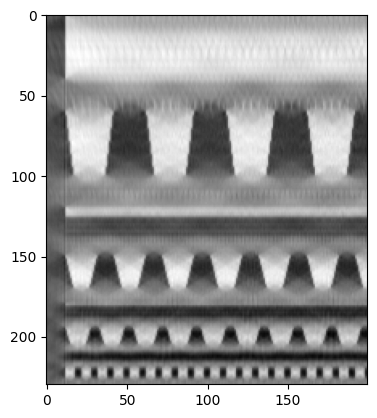

In [ ]:
from skimage import io

## load image with artifacts for testing
img_input = tf.imread("./img_test/lamni_recon_slice.tif")

plt.imshow(img_input, cmap='gray')

# **One Time Correction - Post Processing**

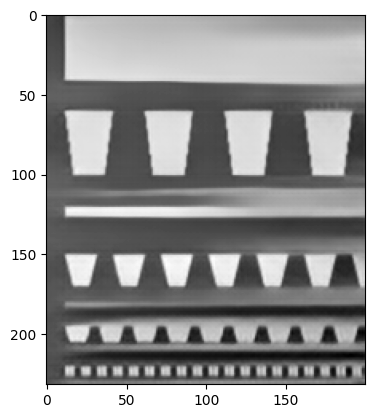

In [ ]:
## NN_PostCorrect is used for one time post correction for 2D images or RGB format images.

## The input images need to be normalized. If there is no pixel with extreme outlier intensity
## rescale and normalize the image based on absolute max and min within this image, using 'self'.

model_output = NN_PostCorrect(img_input, Model, norm="self")

plt.imshow(model_output, cmap='gray')

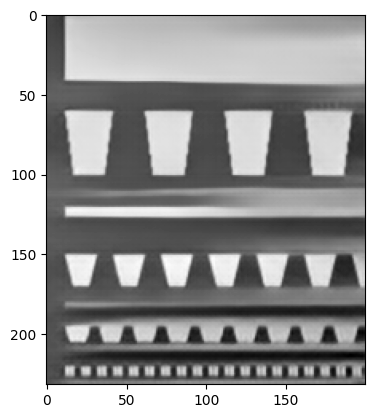

In [ ]:
## 2. rescale based on percentile value in a image

## To prevent effect of outlier on rescale and normalization, use percentile value to replace absolute max and min value
## This is usually used for preventing the effect of outlier pixel problem
## e.g. norm_quant = 0.01, the adjusted max value is the value at 99% quantile, and adjusted min is the value at 1% quantile
## similarly, norm_quant = 0.02, the adjusted max value is the value at 98% quantile, and adjusted min is the value at 2% quantile

model_output = NN_PostCorrect(img_input, Model, norm="self_quant", norm_quant = 0.02)

plt.imshow(model_output, cmap='gray')

# **Iterative correction with PFITRE on 2D image**

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 10/10 [00:02<00:00,  3.95it/s]


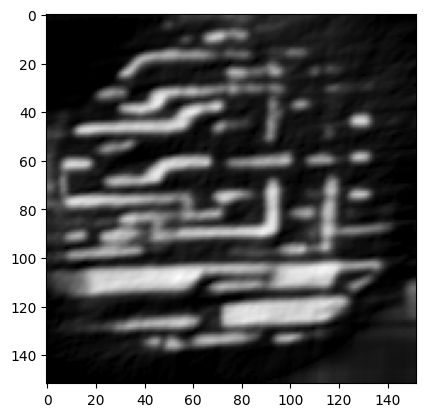

In [ ]:
## recon_ADMM_NN_TV is used for iterative correction on 2D images

Model = PFITRE_net()
model_weights_path = './mdl_weight/ckpt_PFITRE.pth'

## load weight for pretrained network
Model = NN_load(Model, model_weights_path)

#################

## Experimental result 1
sinogram_input_limited = tf.imread("./img_test_XRF/Cu_example_23_LimitedAngle.tiff")[:,40,:]
angle_list_limited = np.array(pd.read_csv('./img_test_XRF/Cu_example_23_LimitedAngle.csv')['angle'])
theta_limited = np.array(angle_list_limited/180*np.pi)

## recon is the result from the final iteration, and x_list saved correction after each iteration
recon, x_list = recon_ADMM_NN_TV(sinogram_input_limited, theta_limited, Model, iter_num=10, ADMM_rho_const=20, cor_shift=-0.5, initial=None, mask_boundary=False, mask_ratio=0.95, norm_quant=0.05, TV=True)

plt.imshow(recon, cmap='gray')

100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


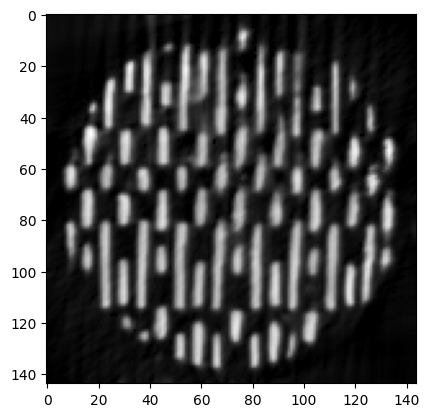

In [ ]:
## Experimental result 2
sinogram_input_limited = tf.imread("./img_test_XRF/Cu_example_22_LimitedAngle.tiff")[:,90,:]
angle_list_limited = np.array(pd.read_csv('./img_test_XRF/Cu_example_22_LimitedAngle.csv')['angle'])
theta_limited = np.array(angle_list_limited/180*np.pi)

## recon is the result from the final iteration, and x_list saved correction after each iteration
recon, x_list = recon_ADMM_NN_TV(sinogram_input_limited, theta_limited, Model, iter_num=10, ADMM_rho_const=25, cor_shift=-0.5, initial=None, mask_boundary=False, mask_ratio=0.95, norm_quant=False, TV=True)

plt.imshow(recon, cmap='gray')

100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


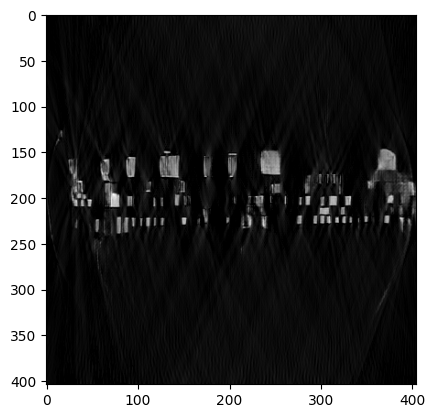

In [ ]:
## Experimental result 3
sinogram_input_limited = tf.imread("./img_test_XRF/Cu_example_24_LimitedAngle.tiff")[:,40,:]
angle_list_limited = np.array(pd.read_csv('./img_test_XRF/Cu_example_24_LimitedAngle.csv')['angle'])
theta_limited = np.array(angle_list_limited/180*np.pi)

## recon is the result from the final iteration, and x_list saved correction after each iteration
recon, x_list = recon_ADMM_NN_TV(sinogram_input_limited, theta_limited, Model, iter_num=10, ADMM_rho_const=25, cor_shift=-0.5, initial=None, mask_boundary=False, mask_ratio=0.95, norm_quant=False, TV=False)

plt.imshow(recon, cmap='gray')

# **Iterative correction with PFITRE on 3D image stack**

In [ ]:
sinogram_input_limited3D = tf.imread("./img_test_XRF/Cu_example_24_LimitedAngle.tiff")
angle_list_limited = np.array(pd.read_csv('./img_test_XRF/Cu_example_24_LimitedAngle.csv')['angle'])
theta_limited = np.array(angle_list_limited/180*np.pi)


recon_3d =[]
## iteratively process each slide within 3D image stack
## apply recon_ADMM_NN_TV to each slide

for i in range(sinogram_input_limited3D.shape[1]):

    sinogram_input_limited_slide = sinogram_input_limited3D[:,i,:]

    recon, x_list = recon_ADMM_NN_TV(sinogram_input_limited_slide, theta_limited, Model, iter_num=10, ADMM_rho_const=25, cor_shift=-0.5, initial=None, mask_boundary=False, mask_ratio=0.95, norm_quant=False, TV=False)
    recon_3d.append(recon)

recon_3dy = np.float32(np.array(recon_3d))